Título do Trabalho:Análise de Imagens Citológicas com SVM e Transfer Learning

Descrição: Neste trabalho será desenvolvido um sistema de apoio ao diagnóstico para detetar metástases em gânglios linfáticos de pacientes com cancro da mama, com recurso a imagens citológicas e dados suplementares do dataset SLN-Breast.

Serão aplicados métodos de Machine Learning (ML), nomeadamente:

Support Vector Machine (SVM)
Redes Neuronais clássicas (NN)
Adicionalmente, será explorado um método de Deep learning(DL) com recurso a Transfer Learning (TL), recorrendo a modelos pré-treinados para extrair características das imagens de patologia.

Os modelos serão avaliados com métricas como exatidão, precisão, sensibilidade e matriz de confusão, comparando o desempenho entre abordagens clássicas e baseadas em deep learning.

In [1]:
#Importação de bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide #para carregar os ficheiros .svs
import os
from PIL import Image
from tqdm import tqdm  # barra de progresso
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


2025-05-12 23:15:12.426885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Carregamento e visualização do DataSet

In [ ]:
#carregar e visualizar as imagens 

# Caminho para a pasta onde estão os ficheiros .svs
image_folder = "/Volumes/PHILIPS_UFD/SLN-Breast"
image_files = os.listdir(image_folder)

# Aumentar o limite de pixels para evitar o erro DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

#Carregar e mostrar uma imagem de exemplo
img_path = os.path.join(image_folder, image_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.title("Exemplo de imagem citológica")
plt.axis('off')
plt.show()

In [15]:
# Carregar dados suplementares
df = pd.read_csv("/Volumes/PHILIPS_UFD/PKG-SLN-Breast/target.csv")

# Visualizar as primeiras linhas
print(df.head())

# Verificar distribuição das classes
print(df['target'].value_counts())

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/PHILIPS_UFD/PKG-SLN-Breast/target.csv'

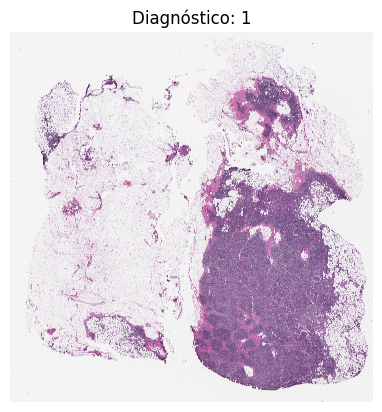

In [5]:
#Combinar as imagens com os dados do CSV
# Exemplo: carregar uma imagem com base no nome no CSV
sample = df.iloc[0]
img_path = os.path.join(image_folder, sample['slide'])
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Diagnóstico: {sample['target']}")
plt.axis('off')
plt.show()


Pré-processamento

O que é que está ser feito e porquê?  Extraímos uma parte da imagem com área de 1000x1000 em vez da imagem completa com zoom 0 (maior resolução) e depois é redimensionado para 224x224 pois é a dimensão que alguns modelos de deep learning esperam. Assim o redimensionamento garente compatibilidade com os modelos. Apesar de poder haver perda de detalhe, permite treinar os modelos de forma mais rápida exigindo menos poder de computação. Existe um compromisso entre a capacidade de computação e preservação da informação. Caso o modelo não tenha uma boa performance ajustamos este redimensionamento. A normalização serve para colocar os valores dos píxeis entre 0.0 e 1.0 para melhorar a eficiência do treino e estabilidade numérica do modelo.

In [7]:
# ---  Pré-processar cada imagem ---
# Lista final com dados
data = []

# Iterar sobre as imagens indicadas no CSV
for file in tqdm(df["slide"]):
    file_path = os.path.join(image_folder, file)

    try:
        slide = openslide.OpenSlide(file_path)

        # Extrair uma região (1000x1000 no nível 0)
        region = slide.read_region((0, 0), 0, (1000, 1000)).convert("RGB")

        # Redimensionar e normalizar
        resized = region.resize((224, 224))
        array = np.array(resized) / 255.0

        # Obter o rótulo correspondente
        label = df[df["slide"] == file]["target"].values[0]

        data.append((array, label))

    except Exception as e:
        print(f"[ERRO] {file}: {e}")

# Separar arrays
X = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])

print("Shape das imagens:", X.shape)
print("Shape dos rótulos:", y.shape)


100%|██████████| 130/130 [00:27<00:00,  4.79it/s]

Shape das imagens: (130, 224, 224, 3)
Shape dos rótulos: (130,)


Modelos de ML (Machine Learning)

1) SVM
2) Neural Networks Simples

In [1]:
# Separar treino e teste
X_flat = X.reshape(X.shape[0], -1)  # Flatten as imagens para SVM
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42) #20% dos dados para teste

# SVM
svm = SVC(kernel='linear', probability=True) #usa fronteira de decisão linear
svm.fit(X_train, y_train) #
y_pred = svm.predict(X_test)

NameError: name 'X' is not defined